# Multi-Lable Classification with MLP

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# import os, sys
# sys.path.append(os.pardir)

from anime_classification import MultiLabelClassifier, Adam, Trainer

## Load Vectorized Synopsis/Genre Data

In [2]:
synop_vec = pd.read_csv('../synopsis_vector/synopsis_vector.csv')
synop_vec.head()

,MAL_ID,0,1,2,3,4,5,6,7,8,...,90,91,92,93,94,95,96,97,98,99
0,1,-0.115295,-3.925781,0.509277,1.326172,2.685547,1.787109,-1.766602,-1.253906,-1.898438,...,0.862305,-0.738770,-1.120117,-0.728516,1.066406,1.273438,-0.247070,1.378906,1.921875,2.218750
1,5,2.314453,-2.363281,-0.013374,2.705078,1.199219,3.171875,-1.359375,-2.605469,-1.960938,...,0.495850,-0.945801,-0.938965,-0.259766,2.087891,1.500000,-0.221924,0.645508,2.220703,0.959473
2,6,-0.225220,-2.599609,-0.183350,2.042969,1.671875,1.951172,-1.367188,-2.916016,-0.161621,...,-1.436523,-1.022461,-2.535156,-2.455078,2.013672,1.943359,0.623047,1.701172,2.359375,1.232422
3,7,0.844727,-0.527344,0.271484,0.753418,1.576172,2.492188,-1.652344,-2.705078,-2.271484,...,-0.366943,-1.791016,-1.804688,-2.474609,2.880859,0.426514,-0.582520,3.105469,0.839355,1.042969
4,8,1.522461,-2.654297,0.423584,1.816406,2.029297,1.697266,0.608887,-1.333008,-1.022461,...,1.652344,-1.703125,-2.476562,-4.488281,1.402344,0.639160,0.059204,1.250000,2.458984,2.517578


In [3]:
genre_vec = pd.read_csv('../clean_data/genre.csv')
genre_vec.head()

,MAL_ID,Action,Adventure,Cars,Comedy,Dementia,Demons,Drama,Ecchi,Fantasy,...,Shounen Ai,Slice of Life,Space,Sports,Super Power,Supernatural,Thriller,Vampire,Yaoi,Yuri
0,1,1,1,0,1,0,0,1,0,0,...,0,0,1,0,0,0,0,0,0,0
1,5,1,0,0,0,0,0,1,0,0,...,0,0,1,0,0,0,0,0,0,0
2,6,1,1,0,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,7,1,0,0,0,0,0,1,0,0,...,0,0,0,0,0,1,0,0,0,0
4,8,0,1,0,0,0,0,0,0,1,...,0,0,0,0,0,1,0,0,0,0


## Split Train-Test Set

In [4]:
synop_cols = synop_vec.columns.drop('MAL_ID').tolist()
genre_cols = genre_vec.columns.drop('MAL_ID').tolist()

In [5]:
full_vec = pd.merge(synop_vec, genre_vec)
full_vec.head()

,MAL_ID,0,1,2,3,4,5,6,7,8,...,Shounen Ai,Slice of Life,Space,Sports,Super Power,Supernatural,Thriller,Vampire,Yaoi,Yuri
0,1,-0.115295,-3.925781,0.509277,1.326172,2.685547,1.787109,-1.766602,-1.253906,-1.898438,...,0,0,1,0,0,0,0,0,0,0
1,5,2.314453,-2.363281,-0.013374,2.705078,1.199219,3.171875,-1.359375,-2.605469,-1.960938,...,0,0,1,0,0,0,0,0,0,0
2,6,-0.225220,-2.599609,-0.183350,2.042969,1.671875,1.951172,-1.367188,-2.916016,-0.161621,...,0,0,0,0,0,0,0,0,0,0
3,7,0.844727,-0.527344,0.271484,0.753418,1.576172,2.492188,-1.652344,-2.705078,-2.271484,...,0,0,0,0,0,1,0,0,0,0
4,8,1.522461,-2.654297,0.423584,1.816406,2.029297,1.697266,0.608887,-1.333008,-1.022461,...,0,0,0,0,0,1,0,0,0,0


In [6]:
# random shuffle and re-index
full_vec = full_vec.sample(frac=1).reset_index(drop=True)
full_vec.head()

,MAL_ID,0,1,2,3,4,5,6,7,8,...,Shounen Ai,Slice of Life,Space,Sports,Super Power,Supernatural,Thriller,Vampire,Yaoi,Yuri
0,1604,1.703125,-0.337158,0.662109,2.525391,1.353516,1.870117,-1.896484,-1.650391,-1.723633,...,0,0,0,0,1,0,0,0,0,0
1,5131,1.948242,-1.543945,1.739258,1.111328,0.900879,1.716797,-1.480469,-1.436523,-1.248047,...,0,0,0,0,0,0,0,0,0,0
2,454,2.005859,-5.664062,-0.310547,0.085266,2.169922,4.535156,0.533691,-4.253906,-1.231445,...,0,0,0,0,0,0,0,0,0,0
3,1412,1.216797,-2.410156,-0.643066,2.693359,1.911133,1.754883,-4.507812,-4.882812,-2.072266,...,0,0,0,0,0,0,0,0,0,0
4,40167,2.726562,-3.205078,-1.408203,4.582031,4.050781,-0.816895,-2.482422,-1.923828,-4.441406,...,0,0,0,0,0,0,0,0,0,0


In [7]:
train_ratio = 0.7

num_train = int(len(full_vec) * train_ratio)

x_train = full_vec[synop_cols][:num_train].values
t_train = full_vec[genre_cols][:num_train].values

x_test = full_vec[synop_cols][num_train:].values
t_test = full_vec[genre_cols][num_train:].values

del synop_vec, genre_vec, full_vec

In [8]:
x_train_mean = x_train.mean(axis=0)
x_train_std  = x_train.std(axis=0)

x_train = (x_train - x_train_mean) / x_train_std
x_test  = (x_test  - x_train_mean) / x_train_std

## Define Model

In [9]:
input_size  = len(synop_cols)
output_size = len(genre_cols)

model = MultiLabelClassifier(input_size, output_size)
optimizer = Adam()
trainer = Trainer(model, optimizer)

## Train Model

In [10]:
num_epochs = 10
batch_size = 100
eval_interval = 100

trainer.fit(x_train, t_train, x_test, t_test, 
            max_epoch=num_epochs, 
            batch_size=batch_size)

/home/dohun/repos/anime-genre-classification/model/anime_classification.py:102: RuntimeWarning: invalid value encountered in true_divide
  dx = -(self.t / self.pt) * dout
| epoch   1 | time   1[s] | train loss  nan | val loss  nan
| epoch   2 | time   1[s] | train loss  nan | val loss  nan
| epoch   3 | time   2[s] | train loss  nan | val loss  nan
| epoch   4 | time   3[s] | train loss  nan | val loss  nan


KeyboardInterrupt: 

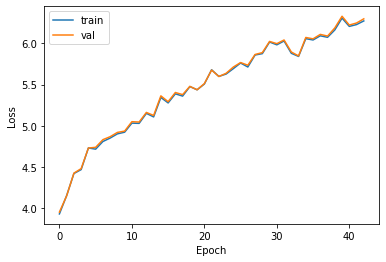

In [11]:
trainer.plot()

In [12]:
gen = np.array(genre_cols)

model.set_train_flag(False)
y_test = model.predict(x_test)

for i in range(10, 20):
    pred = gen[y_test[i] > 0.5]
    true = gen[t_test[i]==1]

    print(pred)
    print(true)
    print()

['Action' 'Adventure' 'Cars' 'Comedy' 'Dementia' 'Demons' 'Drama' 'Ecchi'
 'Fantasy' 'Game' 'Harem' 'Hentai' 'Historical' 'Horror' 'Josei' 'Kids'
 'Magic' 'Martial Arts' 'Mecha' 'Military' 'Music' 'Mystery' 'Parody'
 'Police' 'Psychological' 'Romance' 'Samurai' 'School' 'Sci-Fi' 'Seinen'
 'Shoujo' 'Shoujo Ai' 'Shounen' 'Shounen Ai' 'Slice of Life' 'Space'
 'Sports' 'Super Power' 'Supernatural' 'Thriller' 'Vampire' 'Yaoi' 'Yuri']
['Action' 'Adventure' 'Comedy' 'Space']

['Action' 'Adventure' 'Cars' 'Comedy' 'Dementia' 'Demons' 'Drama' 'Ecchi'
 'Fantasy' 'Game' 'Harem' 'Hentai' 'Historical' 'Horror' 'Josei' 'Kids'
 'Magic' 'Martial Arts' 'Mecha' 'Military' 'Music' 'Mystery' 'Parody'
 'Police' 'Psychological' 'Romance' 'Samurai' 'School' 'Sci-Fi' 'Seinen'
 'Shoujo' 'Shoujo Ai' 'Shounen' 'Shounen Ai' 'Slice of Life' 'Space'
 'Sports' 'Super Power' 'Supernatural' 'Thriller' 'Vampire' 'Yaoi' 'Yuri']
['Drama' 'Romance' 'Yaoi']

['Action' 'Adventure' 'Cars' 'Comedy' 'Dementia' 'Demons' 'Drama'